<a href="https://colab.research.google.com/github/weichuzou/B6-Analysis-of-Influencing-Factors-in-Global-Film-Rating/blob/main/B6_Analysis_of_Influencing_Factors_in_Global_Film_Rating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analysis of Influencing Factors in Global Film Rating**


##**1.Problem Definition**

**Project Proposal:** Improving the rating of a movie/TV series will inevitably increase its box office revenue, and understanding the different factors contributing to a movie’s high rating explains its success. We look at over 2.5 million rows of movies and TV series from the IMDB website to understand people's preferences in a show’s composition, and we also look for ways to increase a show’s rating based on selected data. In addition, we analyze the relationship between the rating of movies and their compositions (duration/votes/certificate/etc.) to provide recommendations to increase revenue for production companies.
<br>
<br>
**Data Source:**

*Raw Data Website:*
<br>
__[IMDB Official Dataset Interface](https://www.imdb.com/interfaces/)__
<br>
*Raw Data Source:*
<br>
__[IMDB Official Dataset](https://datasets.imdbws.com/)__
<br>
*Modified Data:*
<br>
__[IMDB Dataset Modified on Kaggle.com](https://www.kaggle.com/datasets/ashishjangra27/imdb-movies-dataset)__
		

*Note:* the raw data is from IMDB official website, and the data on Kaggle is modified by Ashish Jangra, a data scientist from Noida, India. 
<br>
<br>
**Motivation:**
Films and television series are entertainment topics closely related to people’s lives. By analyzing various factors contributing to a successful film, it is meaningful to discover how a movie/series should be produced that is preferred by spectators while bringing the most revenue to the companies producing it. Although it sounds ideal initially, producing an attractive and profitable show with data analytics is not without precedents, such as the success of Netflix’s House of Cards was based on extensive analytics on viewer data. 
<br>
<br>
**Report Summary:**
By examining the effects of `genre`, `certificate`, `duration`, and director on the rating of works, we draw the conclusion that, starting in 2008, consumers began to favor TV dramas over action movies as their preferred genre.Then, the NEWS reappearance may be more popular with the audience. TV shows typically have high average ratings over relatively short periods of time in the certificates, but movies typically have low average ratings during longer average durations. TV shows may therefore earn more money when production costs are not taken into account. We draw the conclusion that the quantity of films a director produces has no bearing on the quality of those films based on the findings of our survey of directors. As a result, the quantity of a filmmaker's film and television productions need not be a major consideration when a film or television company selects a director.

In [ ]:
# Import packages
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import missingno as msno

In [ ]:
# Mount gdrive and read dataset from gdrive
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/ba780/team project/movies.csv')
df.head()

In [ ]:
# Dataset information and description
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2590932 entries, 0 to 2590931
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              object 
 1   name            object 
 2   year            object 
 3   rating          float64
 4   certificate     object 
 5   duration        object 
 6   genre           object 
 7   votes           object 
 8   gross_income    object 
 9   directors_id    object 
 10  directors_name  object 
 11  stars_id        object 
 12  stars_name      object 
 13  description     object 
dtypes: float64(1), object(13)
memory usage: 276.7+ MB


rating
count  2.590932e+06
mean   1.000326e+01
std    1.885600e+00
min    1.000000e+00
25%    1.100000e+01
50%    1.100000e+01
75%    1.100000e+01
max    1.100000e+01

##**2. Data Cleaning**

###**2.1 Check Data Missing Value Status**

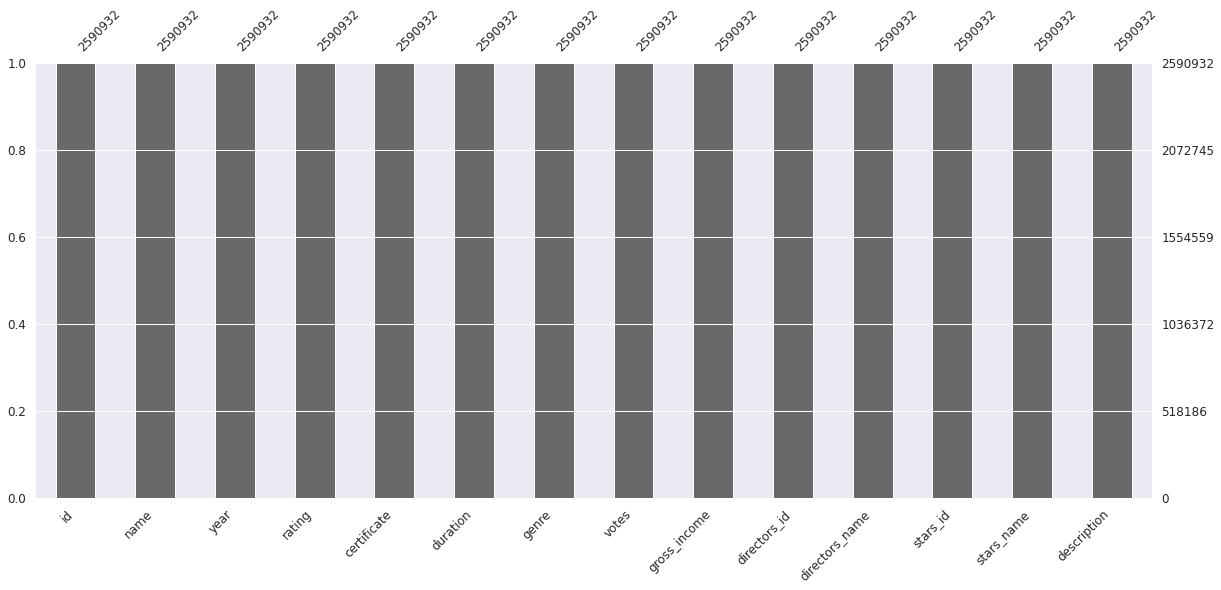

In [ ]:
#Check on the missing values of our dataset 
msno.bar(df, sort="ascending", figsize=(20,8), fontsize=12)
#Our dataset appear to have no missing value (null values)

It seems that there is no missing value in our dataset, however, a further research (Section 2.3) has been done to find the real situation of missing value in the `gross_income` column.

###**2.2 Changing Value Type**
Since this dataset's `year` column is made up of both numbers and character strings, the numbers are taken out and put in a new column, named `p_year`. At the same time, certain unreleased films in this dataset set the year column's value to a year higher than **2022**, therefore these entries need to be removed.

In [ ]:
# Extract year as integer from string, store the processed data into p_year
df['p_year'] = df['year'].str.extract('(\d+)', expand=False)

# Drop null value in p_year (after extraction, there are rows in p_year without an integer value)
df = df.dropna(subset=['p_year'])

# Transfer type of p_year into int
df['p_year'] = df['p_year'].astype(int)

# Removing the movies that have not been published yet (with p_year larger than 2022)
df = df.loc[(df['p_year'] <= 2022)]

As all columns are objects, some continuous variables are changed to int or float values, and some characters — like the separator in `votes` — are eliminated.

In [ ]:
# Extract numeric value from duration, transform data type of duration from object into integer
# Store the processed data into p_duration
df['p_duration']= df['duration'].str.extract('(\d+)', expand = False).astype('int')

# Remove ',' in votes, tranform teh data type of votes from object into float 
# Store the processed data into p_votes
df['p_votes'] = df['votes'].str.replace(',', '').astype('float', errors = 'raise')

# Remove ',' '$', 'M', in gross_income, transform data type from object into float
# Store the processed data into p_gross_income
df['gross_income'] = df['gross_income'].str.replace(',', '')
df['gross_income'] = df['gross_income'].str.replace('$', '')
df['p_gross_income'] = df['gross_income'].str.replace('M', '').astype('float', errors = 'raise')


<ipython-input-48-bec7808dee6b>:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['gross_income'] = df['gross_income'].str.replace('$', '')


###**2.3 `gross_income` Problem**
By querying the unique value of `gross income`, the values of `gross income` in most movies are missing. Moreover, the `gross income` column contains a significant amount of duplicated data, which is inappropriate for a numerical variable. `gross income` must be eliminated. The reason behind this issue might have been IMDB handling lost data improperly during data entering. Therefore, the "total revenue" column will not be used to avoid too many rows being deleted in our analysis。

In [ ]:
# Count unique value in gross income column
print('There are ' + str(len(df['p_gross_income'].unique())) + ' unique values in p_gross_income.')
print('However, there are ' + str(len(df['p_gross_income'])) + ' values in p_gross_income.')

# Move non-zero gross income row into a new datafram
df_gross_income = df[df['p_gross_income'] != 0]
print('After deleting zero values of gross income, there are only ' + str(len(df_gross_income['p_gross_income'])) + ' values left in p_gross_income.')

There are 10654 unique values in p_gross_income.
However, there are 2521504 values in p_gross_income.
After deleting zero values of gross income, there are only 861865 values left in p_gross_income.


###**2.4 Reorganizing the DataFrame**

In [ ]:
# Reorganize the original dataframe with relevant variables for further analysis
df = df[['id', 'name', 'p_year', 'rating', 'certificate', 'p_duration', 'genre', 'p_votes', 'p_gross_income',
         'directors_id', 'directors_name', 'stars_id', 'stars_name', 'description']]
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2521504 entries, 0 to 2590931
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              object 
 1   name            object 
 2   p_year          int64  
 3   rating          float64
 4   certificate     object 
 5   p_duration      int64  
 6   genre           object 
 7   p_votes         float64
 8   p_gross_income  float64
 9   directors_id    object 
 10  directors_name  object 
 11  stars_id        object 
 12  stars_name      object 
 13  description     object 
dtypes: float64(3), int64(2), object(9)
memory usage: 288.6+ MB


p_year        rating    p_duration       p_votes  p_gross_income
count  2.521504e+06  2.521504e+06  2.521504e+06  2.455970e+06    1.701688e+06
mean   2.001403e+03  9.975878e+00  1.599417e+01  4.065205e+02    3.031051e+05
std    1.950942e+01  1.903964e+00  3.243553e+01  1.114478e+04    6.489499e+06
min    1.877000e+03  1.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00
25%    1.994000e+03  1.000000e+01  0.000000e+00  0.000000e+00    0.000000e+00
50%    2.008000e+03  1.100000e+01  0.000000e+00  0.000000e+00    0.000000e+00
75%    2.015000e+03  1.100000e+01  2.100000e+01  5.000000e+00    0.000000e+00
max    2.022000e+03  1.100000e+01  9.990000e+02  2.574832e+06    9.366622e+08

In [ ]:
df.head()

id                          name  p_year  rating    certificate  \
0  tt4710316  Best in Sex: 2015 AVN Awards    2015     4.0          TV-MA   
1  tt1281857              Naughty Novelist    2008     3.8  Not Certified   
2  tt2294954          2011 AVN Awards Show    2011     5.7  Not Certified   
3  tt6843596  Best in Sex: 2017 AVN Awards    2017     4.9          TV-MA   
4  tt3705604               AVN Awards 2014    2014     6.7              R   

   p_duration        genre  p_votes  p_gross_income         directors_id  \
0          94  Adult, News    124.0             0.0            nm1624094   
1          88        Adult    174.0             0.0            nm0045256   
2          83  Adult, News     39.0             0.0  nm1624094,nm0754845   
3          87  Adult, News    225.0             0.0            nm1624094   
4          82  Adult, News    101.0             0.0            nm1624094   

                directors_name                                 stars_id  \
0                  Gary Miller  nm4766272,nm2670531,nm4920605,nm6284246   
1                 John Bacchus  nm0128986,nm1969196,nm0451160,nm6130462   
2  Gary Miller,Timothy E. Sabo  nm2200343,nm2670531,nm1267549,nm3585599   
3                  Gary Miller  nm5221471,nm2670531,nm4920605,nm3038816   
4                  Gary Miller  nm2670531,nm4920605,nm6284246,nm3992720   

                                          stars_name  \
0  Farrah Laurel Abraham,Asa Akira,Anikka Albrite...   
1       Darian Caine,Jackie Stevens,A.J. Khan,Arrora   
2  Aubrey Addams,Asa Akira,Monique Alexander,Rave...   
3  Amirah Adara,Asa Akira,Anikka Albrite,Britney ...   
4  Asa Akira,Anikka Albrite,August Ames,Jessie An...   

                                         description  
0  The hottest adult stars and top adult movies a...  
1  Darian is a successful journalist but when she...  
2                                         Add a Plot  
3  Considered the industry's highest honor, the A...  
4  Erotic filmmaking superstars Chanel Preston an...

###**2.5 Data Description**

| **Feature Name** | **Feature Description** | **Data Type** |
|------------------|-------------------------|---------------|
| id               | Movie ID                                       | object        |
| name             | Name of the Movie                              | object        |
| p_year           | Year of movie release                          | int64         |
| rating           | Rating of the Movie                            | float64       |
| certificate      | Movie Certification                            | object        |
| p_duration       | Duration of the Movie                          | int64         |
| genre            | Genre of the Movie                             | object        |
| p_votes          | Number of people who voted for the IMDB rating | float64       |
| directors_id     | ID of Directors who have worked on the movie   | object        |
| directors_name   | Name of Directors who have worked on the movie | object        |
| stars_id         | ID of stars who have worked on the movie       | object        |
| stars_name       | Name of stars who have worked on the movie     | object        |
| description      | Description of the movie                       | object        |

**Data Cleaning is Completed**

##**3. Detailed Analysis**

### **Heatmap**

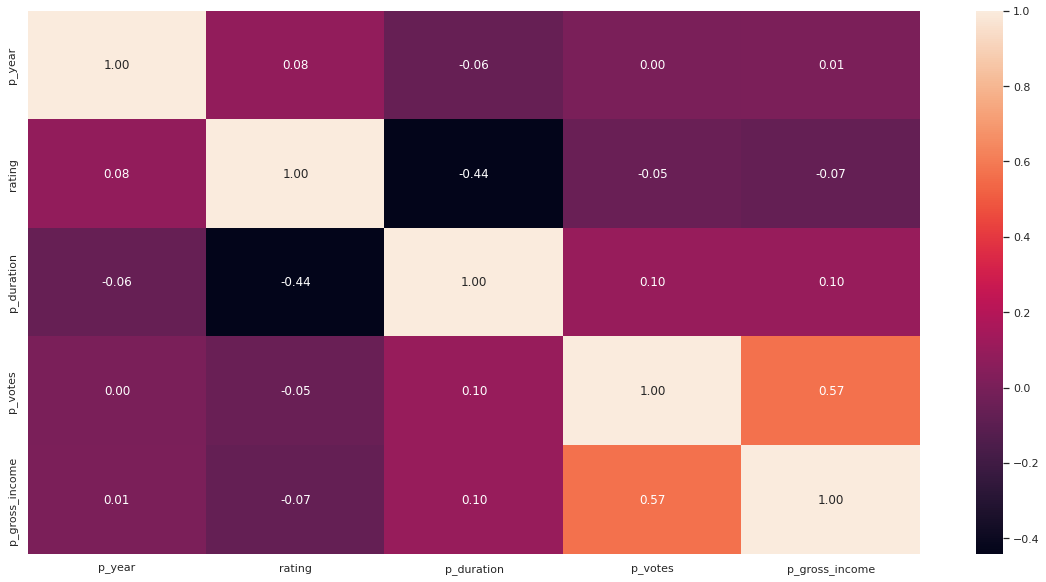

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),fmt=".2f",annot=True)



> Through the heatmap, it can be found that there is a relatively strong negative relationship between `p_duration` and `rating`. As for the relationship between `p_vote` and `p_gross_income`, since the use of `p_gross_income` is abandoned, the relationship between them will no longer be discussed.




### **Roughly Count of Genre**

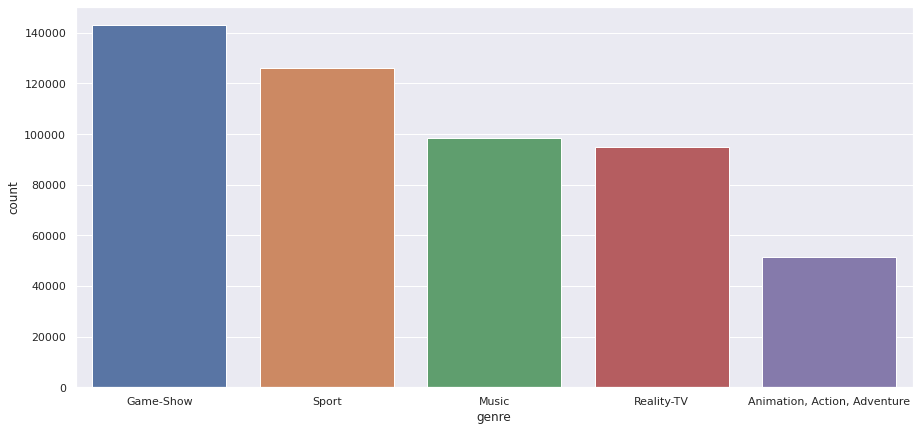

In [ ]:
plt.figure(figsize=(15,7))
sns.countplot(x = df.genre, order = df.genre.value_counts().iloc[:5].index)

plt.show()



> A roughly research has been done to find out top 5 genre with the most quantity. According to the chart above, it can be found that the genre with the largest number is game-show, followed by Sport, Music and Reality-TV.


### **Analysis of Movies' Quantity**

In [ ]:
# Count the quantity of movies/TV group by year
pre = df.groupby(by ='p_year').agg({"id":"count"}).rename(columns={'id': 'Count'})

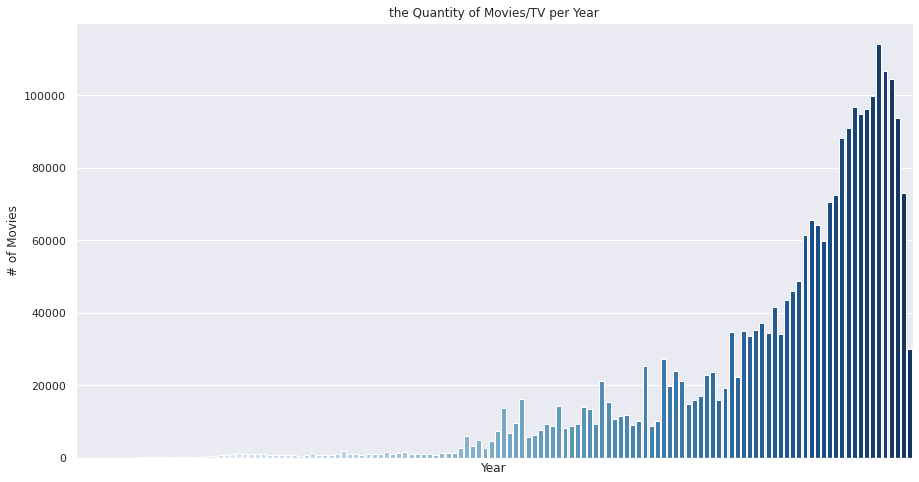

In [ ]:
# Make barplot for the quantity of movies/TV group by year
plt.figure(figsize = (15, 8))
plt.title('the Quantity of Movies/TV per Year')
ax = sns.barplot(x = pre.index,y ='Count',data=pre, palette = 'Blues')
ax.set_xticks([])
plt.xticks(rotation = 90)
plt.xlabel('Year')
plt.ylabel('# of Movies')
plt.show()



> From the graph above, it can be found that most of the film and television products were born in recent decades. This analysis wants to compare the changing trends of film and television products, so ***the median of the year will be used as a dividing line to compare the differences in film and television products***.



### **Preliminary Analysis of `Genre`**

IMDB marks unrated or unvoted movies as 10 or 11, and this has appeared in a large part of the entire dataset. Therefore, this part of the dataset needs to be removed separately in a new *dataframe* to avoid affecting the integrity of the entire dataset. Unvoted and 0-duration films are also removed.

In [ ]:
# Check the description of rating column
df['rating'].describe()

# Remove unrated movies, which has rating of 10 or 10+
df_q = df[df['rating'] < 10]

# Remove unvoted movies and movies with duration equals to 0 minutes
df_q = df_q[(df_q['p_votes'] != 0) & (df_q['p_duration'] != 0)]


Since some movies have multiple genres, the genre list is then splited into multiple rows, so the movie `id` is having a one-to-many relationship with `genre` (one movie can have different genres, therefore appears in multiple rows.) 

In [ ]:
# Expand genre list into several rows
df_q1 = df_q
df_q1['genre'] = df_q1['genre'].map(lambda x: x.split(','))
df_q1 = df_q1.explode('genre')
df_q1.head()

id                          name  p_year  rating    certificate  \
0  tt4710316  Best in Sex: 2015 AVN Awards    2015     4.0          TV-MA   
0  tt4710316  Best in Sex: 2015 AVN Awards    2015     4.0          TV-MA   
1  tt1281857              Naughty Novelist    2008     3.8  Not Certified   
2  tt2294954          2011 AVN Awards Show    2011     5.7  Not Certified   
2  tt2294954          2011 AVN Awards Show    2011     5.7  Not Certified   

   p_duration  genre  p_votes  p_gross_income         directors_id  \
0          94  Adult    124.0             0.0            nm1624094   
0          94   News    124.0             0.0            nm1624094   
1          88  Adult    174.0             0.0            nm0045256   
2          83  Adult     39.0             0.0  nm1624094,nm0754845   
2          83   News     39.0             0.0  nm1624094,nm0754845   

                directors_name                                 stars_id  \
0                  Gary Miller  nm4766272,nm2670531,nm4920605,nm6284246   
0                  Gary Miller  nm4766272,nm2670531,nm4920605,nm6284246   
1                 John Bacchus  nm0128986,nm1969196,nm0451160,nm6130462   
2  Gary Miller,Timothy E. Sabo  nm2200343,nm2670531,nm1267549,nm3585599   
2  Gary Miller,Timothy E. Sabo  nm2200343,nm2670531,nm1267549,nm3585599   

                                          stars_name  \
0  Farrah Laurel Abraham,Asa Akira,Anikka Albrite...   
0  Farrah Laurel Abraham,Asa Akira,Anikka Albrite...   
1       Darian Caine,Jackie Stevens,A.J. Khan,Arrora   
2  Aubrey Addams,Asa Akira,Monique Alexander,Rave...   
2  Aubrey Addams,Asa Akira,Monique Alexander,Rave...   

                                         description  
0  The hottest adult stars and top adult movies a...  
0  The hottest adult stars and top adult movies a...  
1  Darian is a successful journalist but when she...  
2                                         Add a Plot  
2                                         Add a Plot

In [ ]:
genre_div = df_q1.groupby('genre').agg({'id':'count'})
genre_div = genre_div.sort_values(by = 'id', ascending = False)

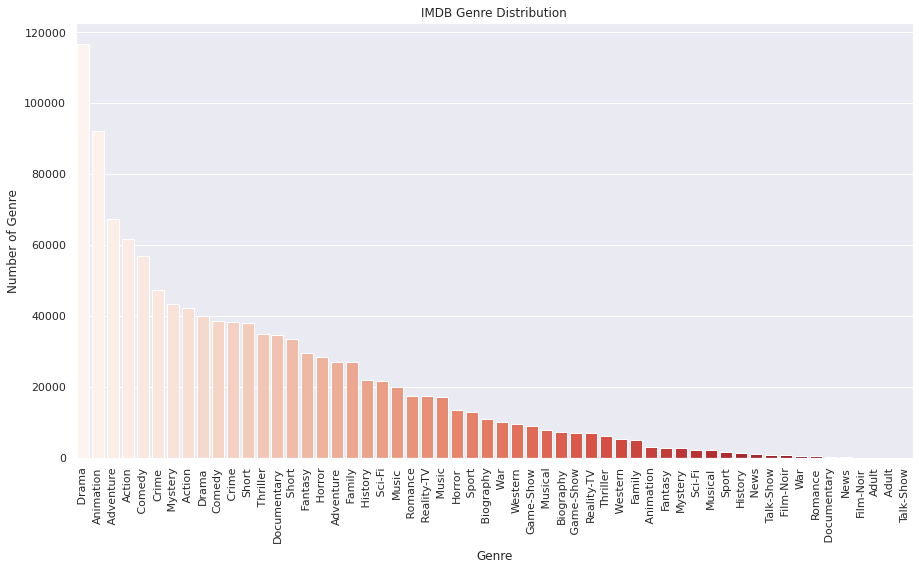

In [ ]:
# Create barplot for the count of genre
plt.figure(figsize = (15, 8))
plt.title("IMDB Genre Distribution")
sns.barplot(x = genre_div.index,y ='id',data=genre_div, palette = 'Reds')
plt.xticks(rotation = 90)
plt.xlabel('Genre')
plt.ylabel('Number of Genre')
plt.show()

### **the Quantity of Drama**

According to the previous analysis, we found that the `genre` with the largest number is `Drama`. But how much does Drama account for the total number of film and television products?

In [ ]:
genre_drama = df_q1.copy()
genre_drama1 = genre_drama[genre_drama['genre'] == 'Drama']
genre_drama0 = genre_drama[genre_drama['genre'] != 'Drama']

In [ ]:
print('There are ' + str(len(genre_drama.id.unique())) + ' movies in total.')

There are 469981 movies in total.


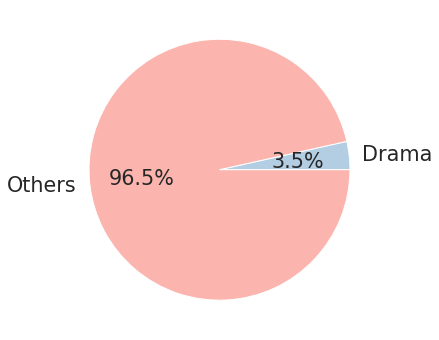

In [ ]:
r_count = genre_drama1.id.count()
f_count = genre_drama0.id.count()
sizes=[r_count/469981,f_count/469981]
plt.figure(figsize=(6,6))
plt.pie(sizes,labels=['Drama','Others'],autopct='%1.1f%%',textprops={'size':'xx-large'},colors=('#B3CDE3','#FBB4AE'));

### **Average Rating for Drama and Others**

So next, we will classify the data sets according to whether they are `Drama` or not, and then see if there is any difference in their average `rating` every year.

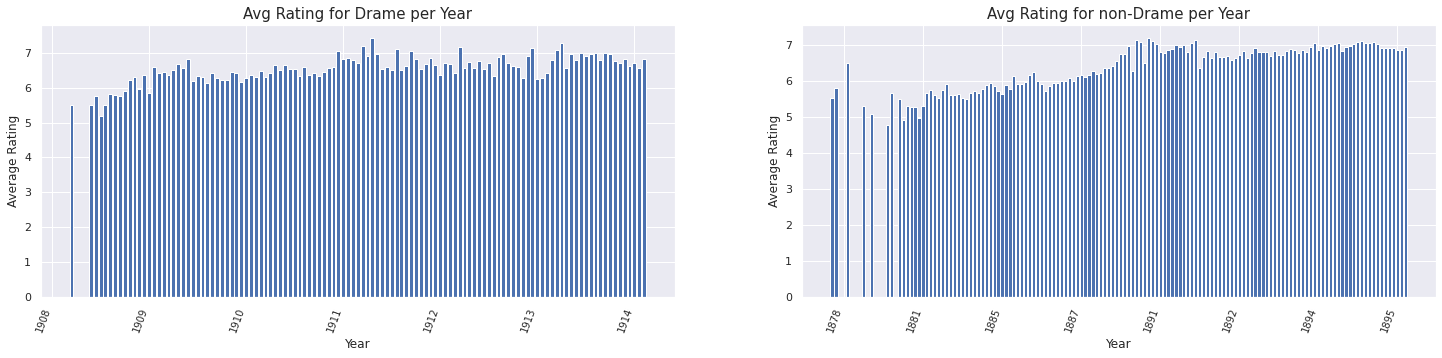

In [ ]:
#Plot a graph describing avaerage rating of drama and else. 
genre_drama1 = genre_drama1.groupby(['p_year']).agg({'rating':'mean'})
genre_drama0 = genre_drama0.groupby(['p_year']).agg({'rating':'mean'})

fig = plt.figure(figsize = (25, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.bar(genre_drama1.index, genre_drama1['rating'])
ax1.set_xticklabels(genre_drama1.index, rotation = 70, horizontalalignment = 'right', fontsize = 10)

ax1.set_title('Avg Rating for Drame per Year', fontsize = 15)
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Rating')

ax2.bar(genre_drama0.index, genre_drama0['rating'])
ax2.set_xticklabels(genre_drama0.index, rotation = 70, horizontalalignment = 'right', fontsize = 10)

ax2.set_title('Avg Rating for non-Drame per Year', fontsize = 15)
ax2.set_xlabel('Year')
ax2.set_ylabel('Average Rating')

plt.show()

According to the above picture, we can find that the rating of Drama seems to be in a very high state all the time, while it seems difficult for other movies to get a high rating in the early stage.

### **the Most Genre per Year**

Find out the genre of film and television filmed the most each year

In [ ]:
genre_year = df_q1.groupby(['p_year','genre'], as_index=False)['id'].count()\
         .sort_values(by=['p_year', 'id'])\
         .drop_duplicates(subset='p_year', keep='last').rename(columns={'id': 'Count'})

In [ ]:
genre_year

p_year      genre  Count
3       1877      Short      2
5       1878  Animation      2
7       1881  Animation      1
9       1885  Animation      1
11      1887      Short      1
...      ...        ...    ...
5151    2018      Drama   3818
5202    2019      Drama   3406
5253    2020      Drama   2648
5307    2021      Drama   2141
5357    2022      Drama    739

[136 rows x 3 columns]

Because the history of film and television is very long, the number of film and television works born every year in the first half of the time is very rare. Therefore, the year when the number of film and television works exceeds the threshold of 10,000 per year will be used as the boundary for research.

In [ ]:
pre[pre['Count'] > 10000].head(5)

Count
p_year       
1956    13611
1959    16220
1965    14227
1969    14040
1970    13470

From the above table, we can find that in ***1956***, the number of film and television works exceeded 10,000 for the first time.

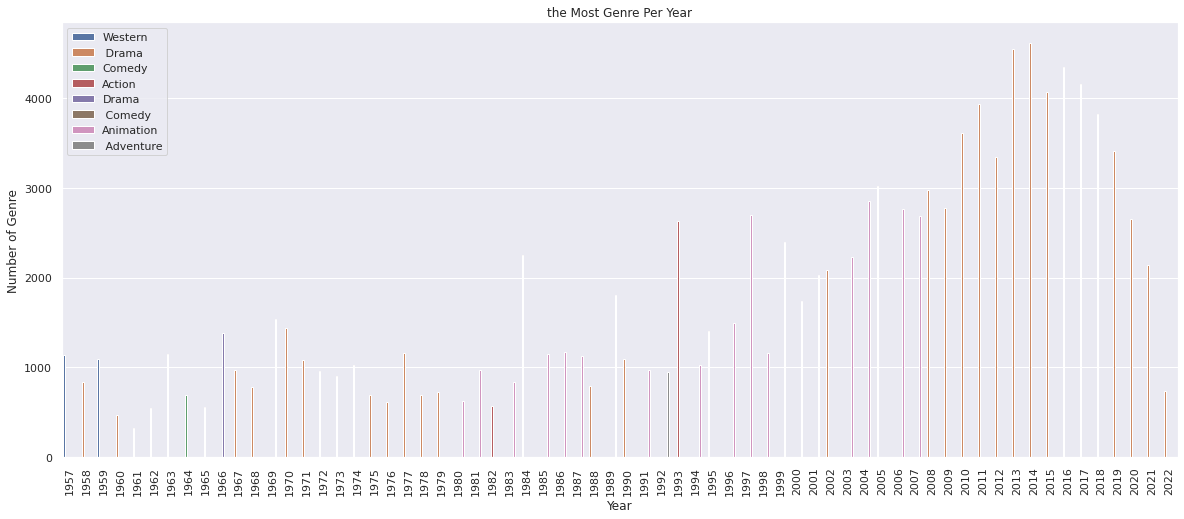

In [ ]:
genre_year = genre_year[genre_year['p_year'] > 1956]
# Create barplot for the count of genre
plt.figure(figsize=(20, 8))
plt.title("the Most Genre Per Year")
sns.barplot(x = 'p_year', y ='Count',data=genre_year, hue = 'genre')
plt.xlabel('Year')
plt.ylabel('Number of Genre')
plt.xticks(rotation = 90)
plt.legend(loc = 'upper left')
plt.show()

### **the Mean Duration of Each Genre**

In [ ]:
genre_count = df_q1.pivot_table(index = 'genre', values = 'p_duration', aggfunc = np.mean).rename(columns = {'p_duration': 'mean_duration'})
genre_count = genre_count.sort_values(by = 'mean_duration', ascending = False)
genre_count

mean_duration
genre                      
Sport            113.338545
War               97.743945
Musical           97.312232
Biography         93.428076
Romance           87.494094
Thriller          86.787481
News              83.967742
 Film-Noir        83.584469
Film-Noir         80.787879
Horror            80.494534
Adult             79.357143
 War              79.109743
 Romance          76.691669
Drama             75.907722
Mystery           75.718984
History           75.491241
Action            74.206068
 Musical          73.956637
 Thriller         73.643509
 Sport            73.499844
 History          73.308686
Crime             67.303965
Sci-Fi            67.274619
 Biography        67.076321
Adventure         64.357612
Fantasy           64.217497
Documentary       63.995509
 Talk-Show        62.570900
 Crime            61.278272
 Drama            60.452764
 Mystery          60.412487
Talk-Show         60.000000
Comedy            59.937237
 Music            59.152499
 Western          58.195914
 Adult            57.400000
 Documentary      57.054545
Western           53.476519
 Fantasy          50.883168
 Sci-Fi           49.265773
Game-Show         48.667686
 Horror           48.010271
Reality-TV        46.164904
 Reality-TV       46.087717
 Game-Show        45.890395
 News             45.830076
 Family           41.555786
Family            41.458428
 Comedy           37.089671
 Adventure        36.165166
 Action           25.298623
Music             24.461809
Animation         23.245106
 Animation        21.209966
Short             13.702995
 Short            12.623448

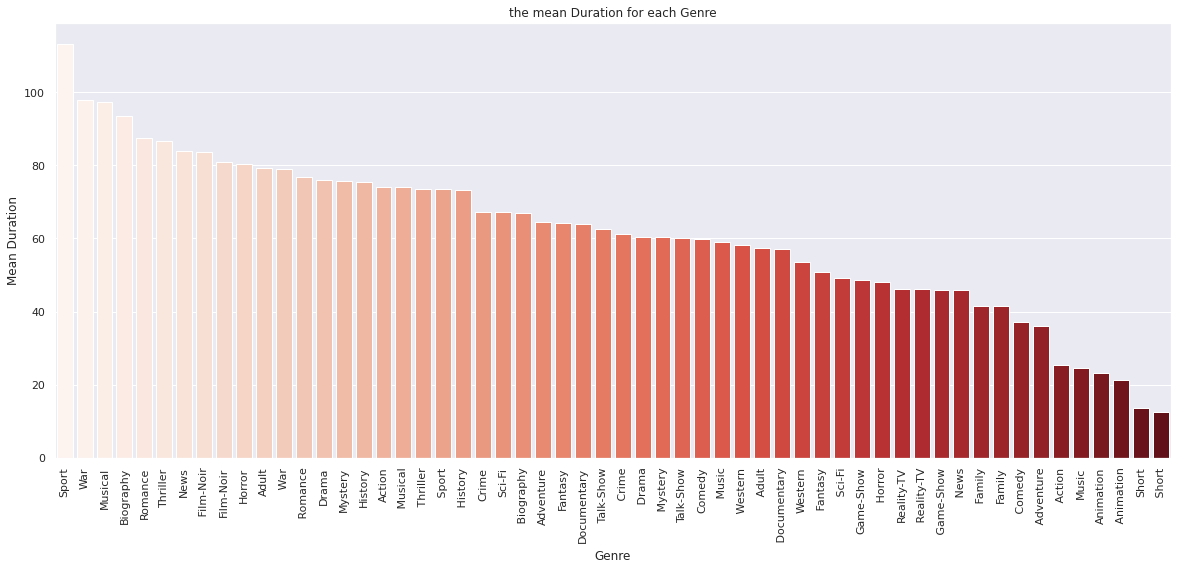

In [ ]:
# Create barplot for the mean duration group by genre
plt.figure(figsize=(20, 8))
plt.title("the mean Duration for each Genre")
sns.barplot(x = genre_count.index, y ='mean_duration',data=genre_count, palette = 'Reds')
plt.xlabel('Genre')
plt.ylabel('Mean Duration')
plt.xticks(rotation = 90)
plt.show()

### **the Mean Rating for Each Genre**

In [ ]:
genre_rating = df_q1.pivot_table(index = 'genre', values = 'rating', aggfunc = np.mean).rename(columns = {'rating': 'mean_rating'})
genre_rating = genre_rating.sort_values(by = 'mean_rating', ascending = False)
genre_rating

mean_rating
genre                    
Talk-Show        8.600000
 Action          7.335888
Documentary      7.318490
 Biography       7.266231
 History         7.260782
 Game-Show       7.260582
 News            7.235514
History          7.190803
 Documentary     7.188182
 Reality-TV      7.184738
 Adventure       7.162603
 Mystery         7.098679
 Drama           7.090132
Western          7.088809
Animation        7.062482
Crime            7.045267
Sport            6.995610
 Crime           6.988995
 Music           6.987465
 Fantasy         6.987194
Game-Show        6.983073
 Family          6.971116
Biography        6.970801
Short            6.966220
 War             6.949069
 Comedy          6.927483
 Western         6.900439
Adventure        6.891864
 Sport           6.850999
Music            6.791143
Drama            6.789066
Family           6.780029
 Animation       6.763368
Comedy           6.757663
 Talk-Show       6.747719
 Short           6.658184
 Sci-Fi          6.656251
 Romance         6.599325
Film-Noir        6.587879
Reality-TV       6.584278
Action           6.581366
 Film-Noir       6.529700
 Musical         6.520043
Musical          6.510233
 Horror          6.393326
Fantasy          6.333775
Romance          6.307283
Mystery          6.274925
 Thriller        6.269354
War              6.234948
News             6.048387
Adult            5.942857
Sci-Fi           5.765742
Thriller         5.722331
Horror           4.929088
 Adult           4.620000

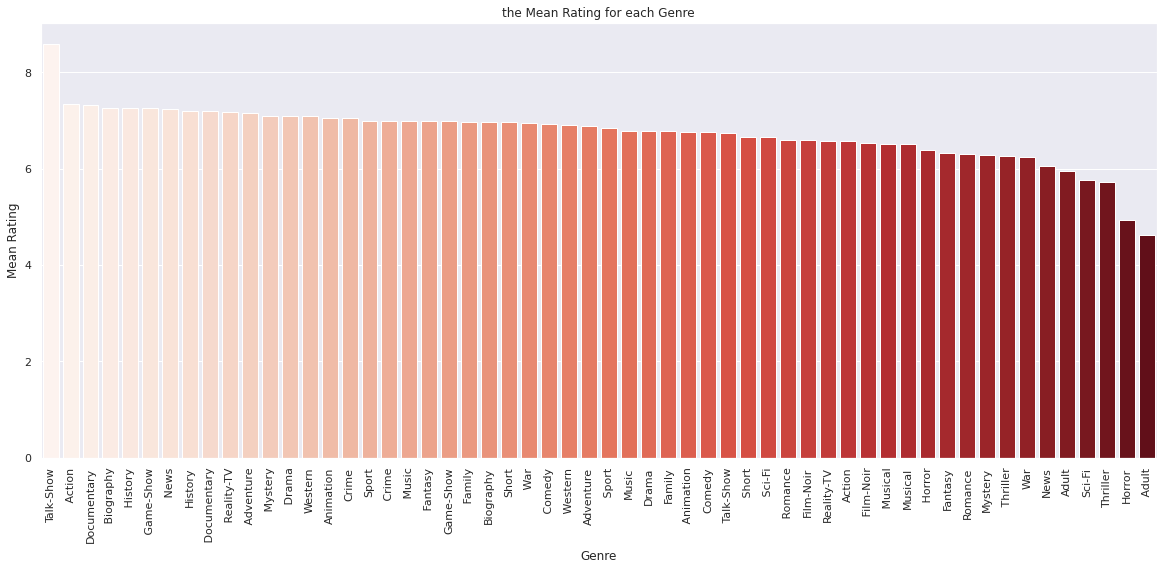

In [ ]:
# Create barplot for the mean duration group by genre
plt.figure(figsize=(20, 8))
plt.title("the Mean Rating for each Genre")
sns.barplot(x = genre_rating.index, y ='mean_rating',data=genre_rating, palette = 'Reds')
plt.xlabel('Genre')
plt.ylabel('Mean Rating')
plt.xticks(rotation = 90)
plt.show()

###**3.1 Question 1**
**Based on the ratings, find the median of all the years in which the movies are presented. What has happened in audience taste for genres during first half of the years compared with the second half of the years?**

In [ ]:
#Check the median of years of all movies
print('Median of Years:', round(df['p_year'].median()))

Median of Years: 2008


The average `rating` for each `genre` should then be calculated separately for the rows extracted before and after the year 2008. Finally, create individual bar plots for each of them.

In [ ]:
# Select movies that are produced after 2008
aft_2008 = df_q1[(df_q1['p_year'] > 2008) & (df_q1.id)]

# Select movies that are produced before 2008
be4_2008 = df_q1[(df_q1['p_year'] < 2008) & (df_q1.id)]

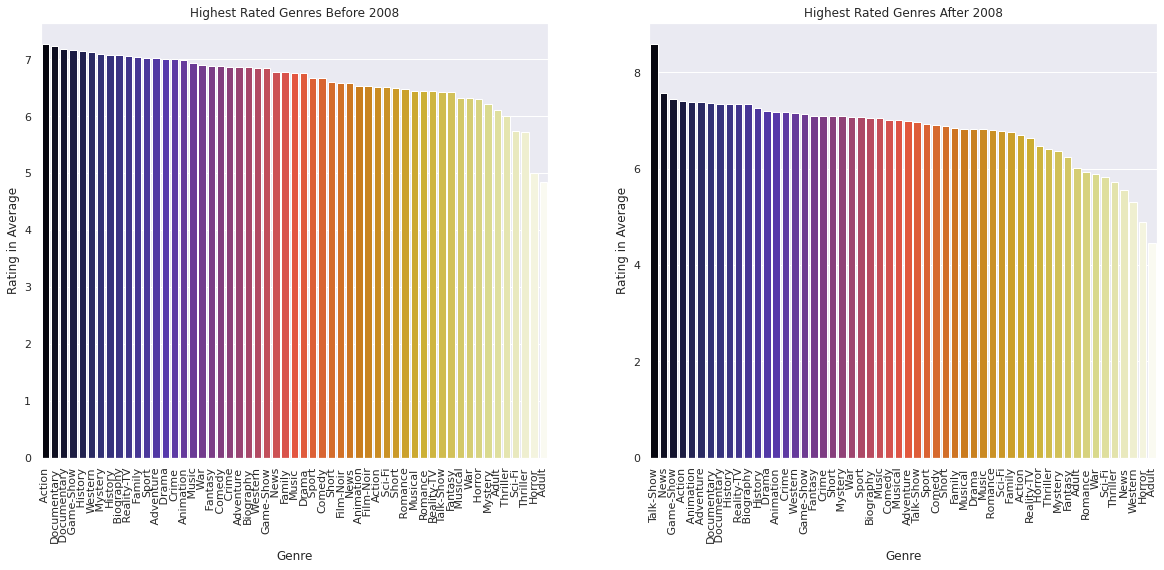

In [ ]:
# Find the average values of rating after 2008 grouped by genre and sort the outcome with descending
genre_df1 = aft_2008.groupby(by ='genre').agg({"rating":"mean"})
genre_df1 = genre_df1.sort_values(by ='rating', ascending = False)
genre_df1

# Find the average values of rating before 2008 grouped by genre and sort the outcome with descending
genre_df2 = be4_2008.groupby(by ='genre').agg({"rating":"mean"})
genre_df2 = genre_df2.sort_values(by ='rating', ascending = False)
genre_df2

# Make barplot for the average rating of each genre
plt.figure(figsize = (20, 8))
sns.color_palette("vlag", as_cmap=True)

plt.subplot(1, 2, 1)
plt.title('Highest Rated Genres Before 2008')
sns.barplot(x = genre_df2.index, y ='rating', data = genre_df2, palette = 'CMRmap')
plt.xlabel('Genre')
plt.ylabel('Rating in Average')
plt.xticks(rotation = 90)

plt.subplot(1, 2, 2)
plt.title('Highest Rated Genres After 2008')
sns.barplot(x = genre_df1.index,y ='rating',data = genre_df1, palette = 'CMRmap')
plt.xticks(rotation = 90)
plt.xlabel('Genre')
plt.ylabel('Rating in Average')
plt.show()

####**Answer to Question 1**


> **The median of `p_year` in which all movies are presented is 2008. In terms of `genre`, we can see a clear difference in the audience's taste before and after 2008. Before 2018, with `Action` being first place, there is not much difference between each genre. However, after 2008, with `Talk-show` being first place, there is a huge gap between `Talk-show` and others.**



#### **Detailed Analysis of Votes by Genre**

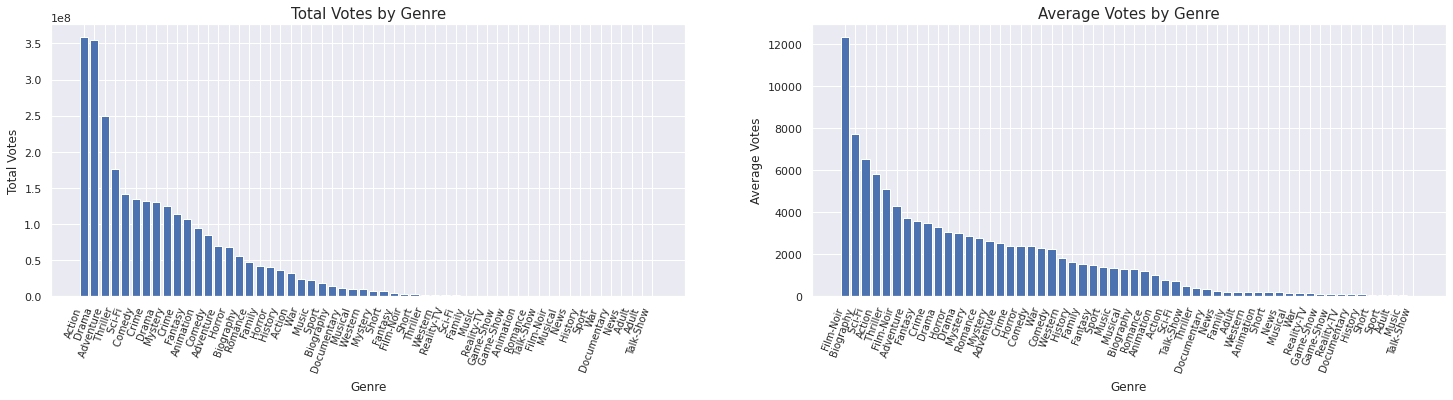

In [ ]:
#Plot a graph describing total/average votes of different genre. 

genre_group = df_q1.groupby(['genre'])
df_q1_genreSum = genre_group.sum().sort_values('p_votes', ascending = False)
df_q1_genreAve = genre_group.mean().sort_values('p_votes', ascending = False)

fig = plt.figure(figsize = (25, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.bar(df_q1_genreSum.index, df_q1_genreSum['p_votes'])
ax1.set_xticklabels(df_q1_genreSum.index, rotation = 70, horizontalalignment = 'right', fontsize = 10)

ax1.set_title('Total Votes by Genre', fontsize = 15)
ax1.set_xlabel('Genre')
ax1.set_ylabel('Total Votes')

ax2.bar(df_q1_genreAve.index, df_q1_genreAve['p_votes'])
ax2.set_xticklabels(df_q1_genreAve.index, rotation = 70, horizontalalignment = 'right', fontsize = 10)

ax2.set_title('Average Votes by Genre', fontsize = 15)
ax2.set_xlabel('Genre')
ax2.set_ylabel('Average Votes')

plt.show()

### **3.2 Question 2**
**Find the films/TV series with the highest rating in `Talk-Show` after 2008, and the films/TV series with the highest rating in `Action` before 2008.**

In [ ]:
# Extract rows after 2008 and genre is equal to Talk-Show
a = aft_2008[['name', 'p_year', 'rating']][(aft_2008['p_year'] >= 2008) & (aft_2008['genre'] == 'Talk-Show')]
a

name  p_year  rating
2145106  Dead Talk Live    2020     8.6

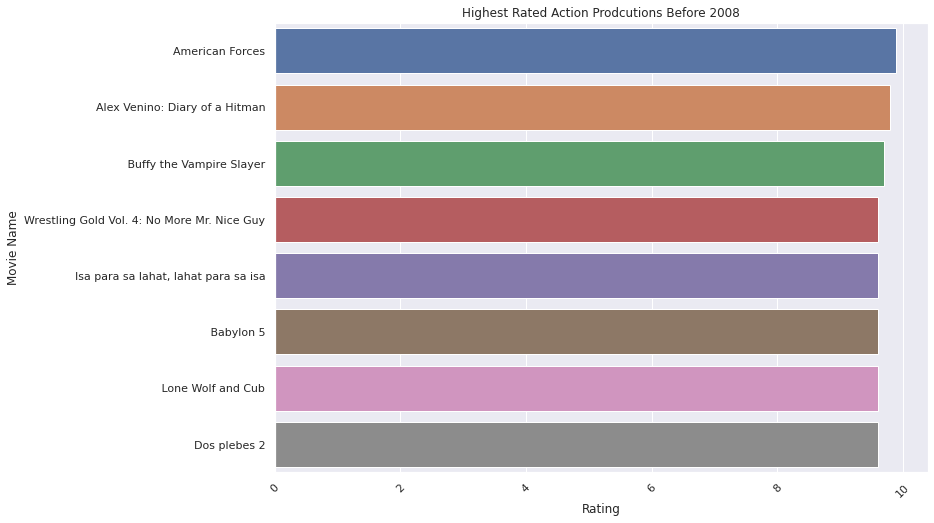

<Figure size 1440x576 with 0 Axes>

In [ ]:
# Extract rows before 2008 and genre is equal to Action
b = be4_2008[['name', 'p_year', 'rating']][(be4_2008['p_year'] < 2008 ) & (be4_2008['genre'] == 'Action')]
b = b.sort_values(by = 'rating', ascending = False).head(10)

# Create barplot for question 2
g = sns.barplot(data = b, y = 'name', x = 'rating')
plt.xticks(rotation = 45)
plt.title("Highest Rated Action Prodcutions Before 2008")
plt.xlabel('Rating')
plt.ylabel('Movie Name')
plt.figure(figsize = (20, 8))
plt.show()

####**Answer to Question 2**


> **From our analysis, the production with the highest rating in the genre `Talk-Show` is `Dead Talk Live`, which is interesting since there is only one product in this genre before 2008. After 2008, the genre with the highest rating: `Action` has the following show being its top-ranked list: `American Forces` , `Alex Venino` , `Buffy the Vampire Slayer`.**


***Analysis of genre and rating in movies ends here.***

***Detailed analysis of certificate and rating in movies begins.***


### **3.3 Question 3**
**Which certificate has the highest average rating?**

There are many inappropriate certificates in the dataset, so the ones that are not adequate for analysis are removed, such as `Banned`. At the same time, ambiguous classifications such as `Passed`, `Approved` etc are also eliminated. The processed dataset in Q3 is also stored separately in a new *dataframe*: `df_q3` to avoid affecting the integrity of the original dataset.

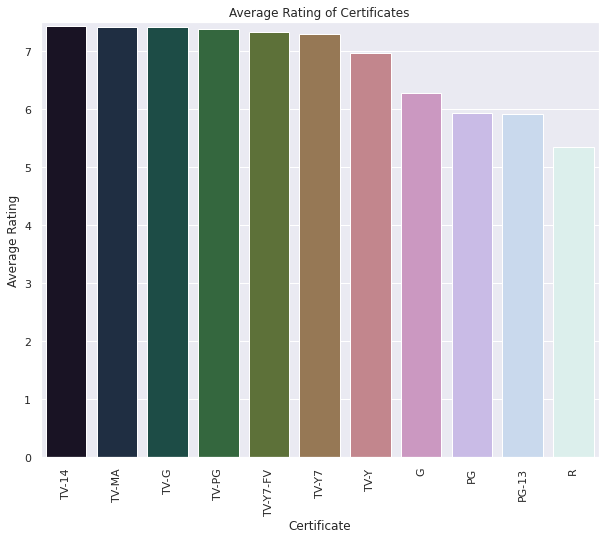

In [ ]:
# Remove inadequate certificate
df_q3 = df_q[(df_q['certificate'] != '(Banned)') &
              (df_q['certificate'] != 'Passed') &
              (df_q['certificate'] != 'Approved') &
              (df_q['certificate'] != 'Banned') &
              (df_q['certificate'] != 'Not Rated') &
              (df_q['certificate'] != 'Unrated') &
              (df_q['certificate'] != 'Open') &
              (df_q['certificate'] != 'Not Certified')]

# Remove certificate less than 1000
df_q3 = df_q3.drop(df_q3.groupby('certificate')['rating'].filter(lambda g: g.count() < 1000).index)
sol = df_q3.groupby('certificate')['rating'].describe().sort_values('mean', ascending = False)

# Plot the graph of certificates with the highest average rating
plt.figure(figsize=(10,8))
g = sns.barplot(x=sol.index, y='mean',data=sol, palette = 'cubehelix')
g.set(ylim = (0, 7.5))
plt.xticks(rotation = 90)
plt.title("Average Rating of Certificates")
plt.xlabel('Certificate')
plt.ylabel('Average Rating')
plt.show()

####**Answer to Question 3**

> **`TV-14`, `TV-MA`, and `TV-G` certificates have the highest average rating, and the lowest average rating certificates are `R`, `PG-13`, and `PG`. Therefore, we conclude that TY series typically enjoy higher ratings than movies on average. We further  analyze the impact of duration on movies and TV series rating.**

### **3.4 Question 4**
**Which certificate of movies has the highest duration on average?**

In [ ]:
# Reuse the certificate column from Question 3
print(df_q3['certificate'].unique())

# Find the average of duration and rating of movies in different certificates
duration_certificate = df_q3.groupby(by='certificate').agg({"p_duration":"mean", 'rating':'mean'}).sort_values('p_duration', ascending = False)
duration_certificate.head()

['TV-MA' 'R' 'PG-13' 'TV-14' 'PG' 'TV-PG' 'TV-Y7-FV' 'TV-G' 'TV-Y7' 'G'
 'TV-Y']


p_duration    rating
certificate                      
PG-13         96.987845  5.928308
R             96.255718  5.349929
PG            92.868856  5.935353
G             53.711132  6.277971
TV-14         44.887398  7.443876

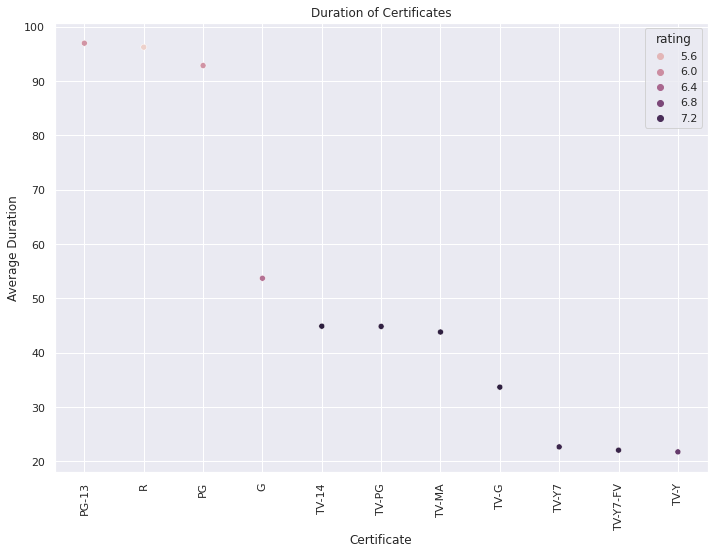

In [ ]:
# Plot the relationship between duration, rating, and certificates 
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data = duration_certificate, x=duration_certificate.index, y = 'p_duration', hue = 'rating')
plt.xticks(rotation=90)
plt.xlabel('Certificate')
plt.ylabel('Average Duration')
plt.title('Duration of Certificates')
plt.show()

####**Answer to Question 4**

> **From the graph, TV series typically enjoy higher ratings on average for a relatively lower duration while movies are rated more poorly for a longer duration on average. Especially movies with an *R* certificate, have one of the longest duration for the poorest rating on average. Interestingly, movies with a *G* certifcate have roughly the same rating with close to all TV series' duration.**

### **3.5 Question 5**
**In addition to the factors discussed in the previous questions, such as `certificate`. Does the director influence on the movie's rating? In this dataset, we can determine the number of films each director has produced. What effect does this element have on the film rating?**

**Movie Rating Problem:** There are many single-digit votes in the dataset with surprisingly high ratings.

**Setting Thresholds for Movie Ratings：**The dataset selected by Q5 is similar to that of Q2, and also retains the rows with high votes to avoid excessive or low scores caused by too few votes. At the same time, Q5 processes the unknown data of the director column. ***Films with votes less than 100 are dropped***, because they are more likely than other data points to be outliers, since they are not representative enough compared to well-know films.

In [ ]:
# Filter out the films with less than 100 votes
df_q5 = df_q[df_q['p_votes'] > 100]

# Reorganize the original dataframe with relevant variables for Question 5
df_q5 = df_q5[['id', 'name', 'p_year', 'rating', 'p_votes', 'directors_id', 'directors_name']]

# Transform type of directors_name and directors_id into string
df_q5['directors_name'] = df_q5['directors_name'].astype('string')
df_q5['directors_id'] = df_q5['directors_id'].astype('string')

# Filter out the films with 'Anonymous' director
df_q5 = df_q5[df_q5['directors_name'] != 'nm0000000']
df_q5 = df_q5[df_q5['directors_name'] != 'Anonymous']

# Some films have multiple directors, the directors_name & directors_id are then splited into multiple rows
# so the movie id is having a one-to-many relationship with directors_name & directors_id (one movie can 
# have different directors, therefore appears in multiple rows.)
df_q5 = (df_q5.set_index(['id', 
                          'name', 
                          'p_year', 
                          'rating', 
                          'p_votes'])
          .apply(lambda x: x.str.split(',').explode())
          .reset_index())                  

df_q5.head()

id                                      name  p_year  rating  \
0  tt4710316              Best in Sex: 2015 AVN Awards    2015     4.0   
1  tt1281857                          Naughty Novelist    2008     3.8   
2  tt6843596              Best in Sex: 2017 AVN Awards    2017     4.9   
3  tt3705604                           AVN Awards 2014    2014     6.7   
4  tt0207195  Wadd: The Life & Times of John C. Holmes    1999     6.8   

   p_votes directors_id  directors_name  
0    124.0    nm1624094     Gary Miller  
1    174.0    nm0045256    John Bacchus  
2    225.0    nm1624094     Gary Miller  
3    101.0    nm1624094     Gary Miller  
4    907.0    nm0256178  Wesley Emerson

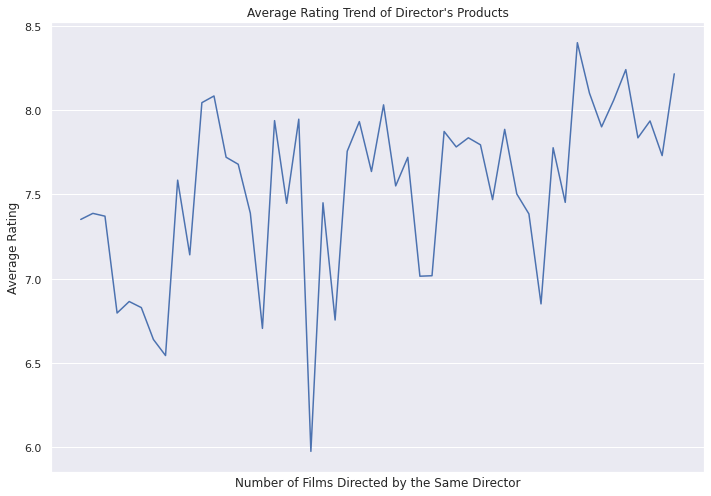

In [ ]:
# Count the number of films have been directed by each director
dic_df1 = df_q5.groupby(by ='directors_name').agg({"id":"count" , "rating":"mean"})
dic_df1 = dic_df1.sort_values(by = 'id', ascending = False)
dic_df1 = dic_df1.head(50)

# Make lineplot to try to find a linear relationship between average ratings and the number of films each director has directed
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.lineplot(data = dic_df1, x=dic_df1.index, y = 'rating')
ax.set_xticks([])
plt.xticks(rotation=90)
plt.xlabel('Number of Films Directed by the Same Director')
plt.title('''Average Rating Trend of Director's Products''')
plt.ylabel('Average Rating')
plt.show()

####**Answer to Question 5**


> **The linear relationship in the figure leads to the conclusion that the `rating` and the director's total number of films are not clearly correlated.**

###**Note: The number of movies that the director has directed decreases from left to right in the graph above.**


##**4. Conclusion**
**By analyzing the influence of `genre`, `certificate`, `duration`, and director on a production's rating, we conclude that after 2008, the audience's taste in genres changed from Action productions to TV-Shows. In certificates, TV series typically enjoy higher ratings on average for a relatively lower duration while movies are rated more poorly for a longer duration on average. From our findings on directors, we conclude that the number of films a director has produced does not have a relationship with the ratings of those films.**

**We make the following recommendations to the production companies based on our analysis:**
1. **Consumers' habit of watching a production in their leisure time has evolved from *action movies*/*tv-series* to *NEWS*.**
1. **TV-series with shorter duration usually have a better chance of obtaining a higher rating than movies with a longer duration.**
1. **A director's total number of production has little to no effect on the quality of those productions, companies should not value too much on the number of productions.**

## **5. Reference**

[1] IMDB weibsite: https://www.imdb.com/?ref_=nv_home

[2] Top 250 films: https://www.imdb.com/chart/top/

[3] Film rating system: https://www.motionpictures.org/film-ratings/

[4] Jargons definition: https://help.imdb.com/article/contribution/titles/certificates/GU757M8ZJ9ZPXB39?ref_=helpart_nav_27#
